In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fichiers trouvés pour la frame 0000000012
Chargement de /content/drive/MyDrive/Colab Notebooks/ Robotique Intelligente/2011_09_26_drive_0001_sync/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000012.png...
Calcul des matrices de calibration...
Lancement de YOLOv8...

Objets détectés :
 - car détecté à  17.07 m
 - car détecté à  26.52 m
 - car détecté à  33.04 m
 - car détecté à  56.39 m
 - truck détecté à  10.33 m
 - car détecté à  43.69 m
 - car détecté à  10.34 m
 - car détecté à  38.61 m
 - car détecté à  76.01 m


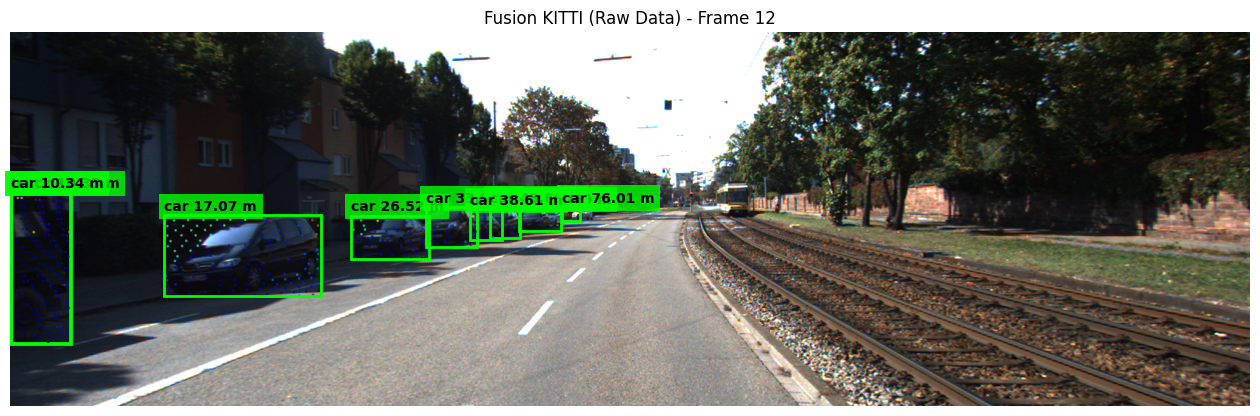

In [ ]:
# ==========================================
# TP FUSION CAMERA - LIDAR
# ==========================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
from google.colab import drive

# Chemins
DRIVE_SYNC = "/content/drive/MyDrive/Colab Notebooks/ Robotique Intelligente/2011_09_26_drive_0001_sync/2011_09_26/2011_09_26_drive_0001_sync"
IMG_DIR = os.path.join(DRIVE_SYNC, "image_02", "data") # Caméra couleur
VELO_DIR = os.path.join(DRIVE_SYNC, "velodyne_points", "data") # LiDAR

# On prend la 12ème image comme exemple
frame_idx = 12
filename = f"{frame_idx:010d}" # Donne "0000000012"

img_path = os.path.join(IMG_DIR, f"{filename}.png")
velo_path = os.path.join(VELO_DIR, f"{filename}.bin")
calib_cam_file = os.path.join("/content/drive/MyDrive/Colab Notebooks/ Robotique Intelligente/2011_09_26/calib_cam_to_cam.txt")
calib_velo_file = os.path.join("/content/drive/MyDrive/Colab Notebooks/ Robotique Intelligente/2011_09_26/calib_velo_to_cam.txt")

# Vérification
if not os.path.exists(img_path):
    print(f"ERREUR : Image non trouvée à : {img_path}")
else:
    print(f"Fichiers trouvés pour la frame {filename}")

# --- 2. FONCTIONS DE PARSING CALIBRATION ---

def parse_kitti_calib_file(filepath):
    """ Lit un fichier calib brut et renvoie un dictionnaire """
    data = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'): continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data

def get_calib_matrices_raw(cam_file, velo_file):
    """ Construit les matrices P2, R0_rect, Tr_velo_to_cam  """

    # 1. Lecture Cam to Cam
    cam_data = parse_kitti_calib_file(cam_file)
    # P_rect_02 (3x4)
    P2 = cam_data['P_rect_02'].reshape(3, 4)
    # R_rect_00 (3x3) -> devient 4x4
    R0 = cam_data['R_rect_00'].reshape(3, 3)
    R0_rect = np.eye(4)
    R0_rect[:3, :3] = R0

    # 2. Lecture Velo to Cam
    velo_data = parse_kitti_calib_file(velo_file)
    # R (3x3) et T (3x1) pour faire Tr_velo_to_cam (4x4)
    R_velo = velo_data['R'].reshape(3, 3)
    T_velo = velo_data['T'].reshape(3, 1)
    Tr_velo_to_cam = np.eye(4)
    Tr_velo_to_cam[:3, :3] = R_velo
    Tr_velo_to_cam[:3, 3] = T_velo.flatten()

    return P2, R0_rect, Tr_velo_to_cam

# --- 3. CHARGEMENT ET PROJECTION ---

# A. Chargement Image
print(f"Chargement de {img_path}...")
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h_img, w_img, _ = image.shape

# B. Chargement LiDAR
# Les fichiers raw .bin contiennent (x,y,z,r)
lidar_point_cloud = np.fromfile(velo_path, dtype=np.float32).reshape(-1, 4)
xyz = lidar_point_cloud[:, :3]

# C. Filtrage (Devant la voiture, x>0)
xyz = xyz[xyz[:, 0] > 0]

# D. Calibration
print("Calcul des matrices de calibration...")
try:
    P2, R0_rect, Tr_velo = get_calib_matrices_raw(calib_cam_file, calib_velo_file)
except FileNotFoundError as e:
    print("\nERREUR CRITIQUE : Fichiers de calibration manquants !")
    print(f"Je cherche : {calib_cam_file}")
    raise e

# E. Projection Mathématique
# 1. Homogène
ones = np.ones((xyz.shape[0], 1))
xyz_hom = np.hstack((xyz, ones))

# 2. Projection : P2 * R0_rect * Tr_velo * Point3D
pts_3d_cam = (R0_rect @ Tr_velo @ xyz_hom.T).T
pts_2d_hom = (P2 @ pts_3d_cam.T).T

# 3. Normalisation
pts_2d = pts_2d_hom[:, :2] / pts_2d_hom[:, 2].reshape(-1, 1)

# 4. Filtrage points hors image
mask = (pts_2d[:, 0] >= 0) & (pts_2d[:, 0] < w_img) & \
       (pts_2d[:, 1] >= 0) & (pts_2d[:, 1] < h_img)
pts_2d_valid = pts_2d[mask]
dist_valid = pts_3d_cam[mask, 2] # Profondeur Z

# --- 4. YOLO & FUSION ---
print("Lancement de YOLOv8...")
model = YOLO('yolov8m.pt')
results = model(image, verbose=False)

plt.figure(figsize=(16, 10))
plt.imshow(image)

print(f"\nObjets détectés :")
for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    conf = float(box.conf)
    cls = int(box.cls)
    label = model.names[cls]

    if label in ['car', 'truck', 'person', 'cyclist'] and conf > 0.25:
        # FUSION
        in_box_mask = (pts_2d_valid[:, 0] >= x1) & (pts_2d_valid[:, 0] <= x2) & \
                      (pts_2d_valid[:, 1] >= y1) & (pts_2d_valid[:, 1] <= y2)

        points_in_box = dist_valid[in_box_mask]

        color = 'red'
        dist_str = ""

        if len(points_in_box) > 0:
            distance = np.median(points_in_box)
            dist_str = f" {distance:.2f} m"
            color = 'lime'

            # Afficher quelques points Lidar pour prouver la fusion
            box_pts = pts_2d_valid[in_box_mask]
            # On sous-échantillonne pour ne pas saturer l'image
            plt.scatter(box_pts[::5, 0], box_pts[::5, 1], s=1, c=points_in_box[::5], cmap='jet', alpha=0.5)

        # Dessin
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor=color, linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1-5, f"{label}{dist_str}", color='black', fontsize=10, weight='bold',
                 bbox=dict(facecolor=color, alpha=0.8, edgecolor='none'))

        if dist_str:
            print(f" - {label} détecté à {dist_str}")

plt.title(f"Fusion KITTI (Raw Data) - Frame {frame_idx}")
plt.axis('off')
plt.show()